**Import Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import cv2
import keras
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.regularizers import l2

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,recall_score,precision_score
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras import optimizers
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

**Load the images and extract the meta data**

In [ ]:
# Load the images.
path = "/kaggle/input/utkface-new/UTKFace"
files = os.listdir(path)

print("Total images:",len(files))

Total images: 23708


In [ ]:
age_labels = []
gender_labels = []
image_paths = []

# Shuffle the image before loading it.
image_filenames = os.listdir(path)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  # Extract the Meta Data from the images.
  image_path = os.path.join(path, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

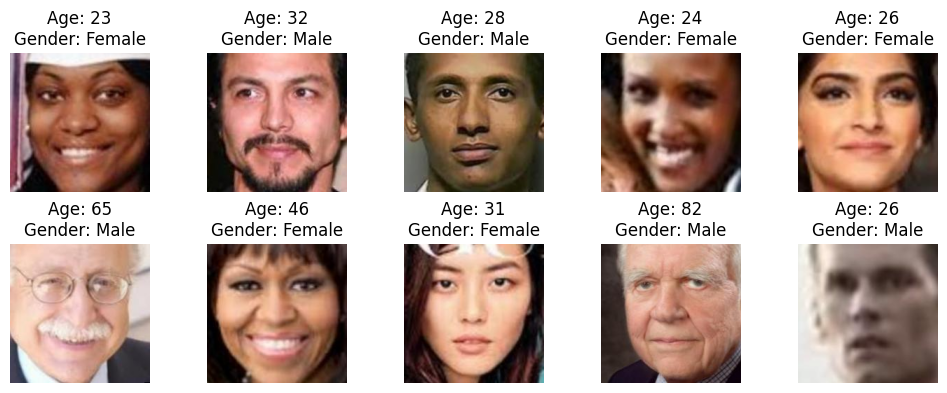

In [ ]:
# Mapping function to convert 0 to 'Male' and 1 to 'Female'
def map_gender_label(gender):
    return 'Male' if gender == 0 else 'Female'

# Create a 2x5 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 10 images and display them
for i in range(10):
    image_path = image_paths[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Map gender label from 0/1 to 'Male'/'Female'
    gender_display = map_gender_label(gender_labels[i])

    axes[i].imshow(image)
    axes[i].axis('off')  # Remove axis ticks
    axes[i].set_title(f"Age: {age_labels[i]}\nGender: {gender_display}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
images = pd.Series(list(image_paths), name="Image_Paths")
ages = pd.Series(list(age_labels), name="Ages")
genders = pd.Series(list(gender_labels), name="Genders")

df = pd.concat([images, ages, genders], axis=1)
df.head()

Image_Paths  Ages  Genders
0  /kaggle/input/utkface-new/UTKFace/23_1_1_20170...    23        1
1  /kaggle/input/utkface-new/UTKFace/32_0_4_20170...    32        0
2  /kaggle/input/utkface-new/UTKFace/28_0_3_20170...    28        0
3  /kaggle/input/utkface-new/UTKFace/24_1_1_20170...    24        1
4  /kaggle/input/utkface-new/UTKFace/26_1_3_20170...    26        1

In [ ]:
df.shape

(23708, 3)

In [ ]:
# Count the occurrences of each gender
genders_count = df["Genders"].value_counts()
genders_count

Genders
0    12391
1    11317
Name: count, dtype: int64

**Exploratory Data Analysis**

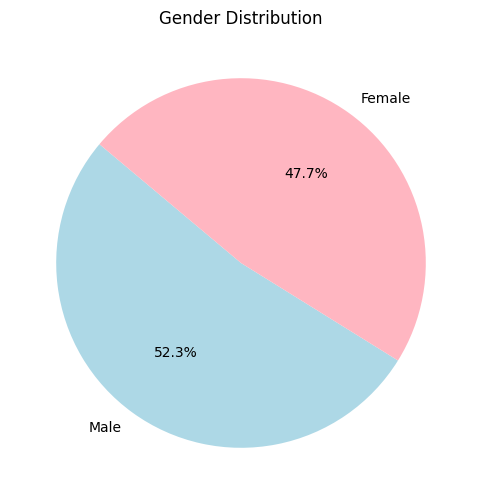

In [ ]:
labels = ['Male', 'Female']
sizes = genders_count.values
colors = ['lightblue', 'lightpink']

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.show()

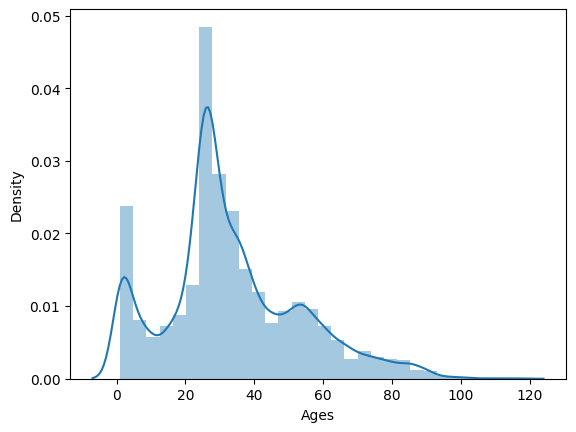

In [ ]:
sns.distplot(df['Ages'],kde=True, bins=30);

**Data Preprocessing**

In [ ]:
# Read the images, reshape it to (128,128),
# finnaly reshape the features as (Num of Sample, height, width, Num of channels).
def image_preprocessing(images):
    features = list()

    for image in tqdm(images):
        img = cv2.imread(image,0)
        # Convert the OpenCV image to a PIL image
        img = Image.fromarray(img)
        img = img.resize((128,128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = image_preprocessing(df["Image_Paths"])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
# Normalization
X = X / 255.0

In [ ]:
y_gender = np.array(df['Genders'])
y_age = np.array(df['Ages'])

# **CNN Model (During Tuning Phase)**

In [ ]:
input_shape = (128,128,1)
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(128, activation='relu')(flatten)
dense_2 = Dense(128, activation='relu')(flatten)

dropout_1 = Dropout(0.5)(dense_1)
dropout_2 = Dropout(0.5)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out', kernel_regularizer=l2(0.001))(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out', kernel_regularizer=l2(0.001))(dropout_2)

model_all = Model(inputs=[inputs], outputs=[output_1, output_2])

model_all.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    optimizer='adam',
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

In [ ]:
model_all.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,179,776 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  1,179,776 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        129 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,747,650 (10.48 MB)

 Trainable params: 2,747,650 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping
#Stops training when val_loss does not improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model_all.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1732945633.373860     101 service.cc:145] XLA service 0x7dc6b0011190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732945633.373917     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732945633.373921     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/593 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - age_out_mae: 32.4654 - gender_out_accuracy: 0.3803 - loss: 33.2338  

I0000 00:00:1732945642.896538     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - age_out_mae: 17.8487 - gender_out_accuracy: 0.5130 - loss: 18.5671 - val_age_out_mae: 14.2811 - val_gender_out_accuracy: 0.6227 - val_loss: 14.9613
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - age_out_mae: 14.1347 - gender_out_accuracy: 0.6175 - loss: 14.7657 - val_age_out_mae: 10.2992 - val_gender_out_accuracy: 0.7674 - val_loss: 10.7856
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - age_out_mae: 11.3959 - gender_out_accuracy: 0.7460 - loss: 11.9001 - val_age_out_mae: 9.4833 - val_gender_out_accuracy: 0.8009 - val_loss: 9.9039
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - age_out_mae: 10.4693 - gender_out_accuracy: 0.7804 - loss: 10.9235 - val_age_out_mae: 8.6439 - val_gender_out_accuracy: 0.8096 - val_loss: 9.0353
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - age_out_mae: 9.5934 - gender_out_accuracy: 0.7956 - loss: 10.0160 - val_age_out_mae: 8.3569 - val_gender_out_accuracy: 0.8237 - val_loss: 8.7206
Ep

In [ ]:
history.history.keys()

dict_keys(['age_out_mae', 'gender_out_accuracy', 'loss', 'val_age_out_mae', 'val_gender_out_accuracy', 'val_loss'])

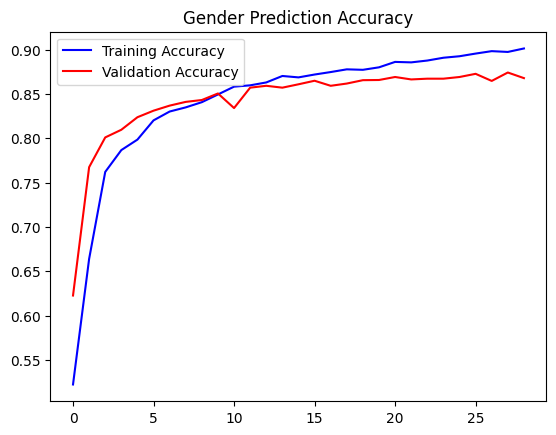

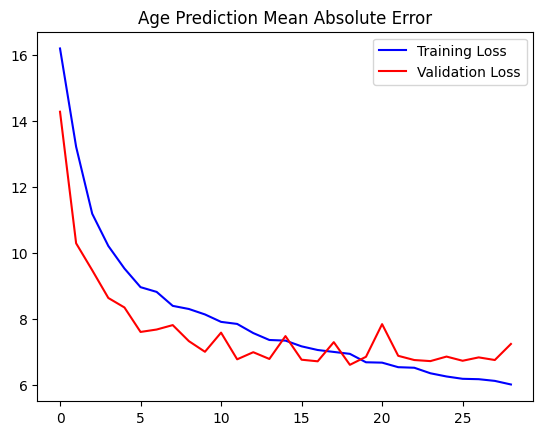

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Prediction Accuracy')
plt.legend()
plt.figure()

# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Age Prediction Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:
model_all.save("model_all.h5")

In [ ]:
def get_image_features(image):
  img = cv2.imread(image, 0)
  img = Image.fromarray(img)
  img = img.resize((128,128), Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

In [ ]:
# Load Some images to test with
path_test = '/kaggle/input/utkface-new/crop_part1'
age_labels_test = []
gender_labels_test = []
image_paths_test = []

image_filenames_1 = os.listdir(path_test)
random.shuffle(image_filenames_1)

for image in tqdm(image_filenames_1):
  image_path_test = os.path.join(path_test, image)
  img_components_test = image.split('_')
  age_label_test = int(img_components_test[0])
  gender_label_test = int(img_components_test[1])

  # Append the image_path, age_label, and gender_label
  age_labels_test.append(age_label_test)
  gender_labels_test.append(gender_label_test)
  image_paths_test.append(image_path_test)

  0%|          | 0/9780 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


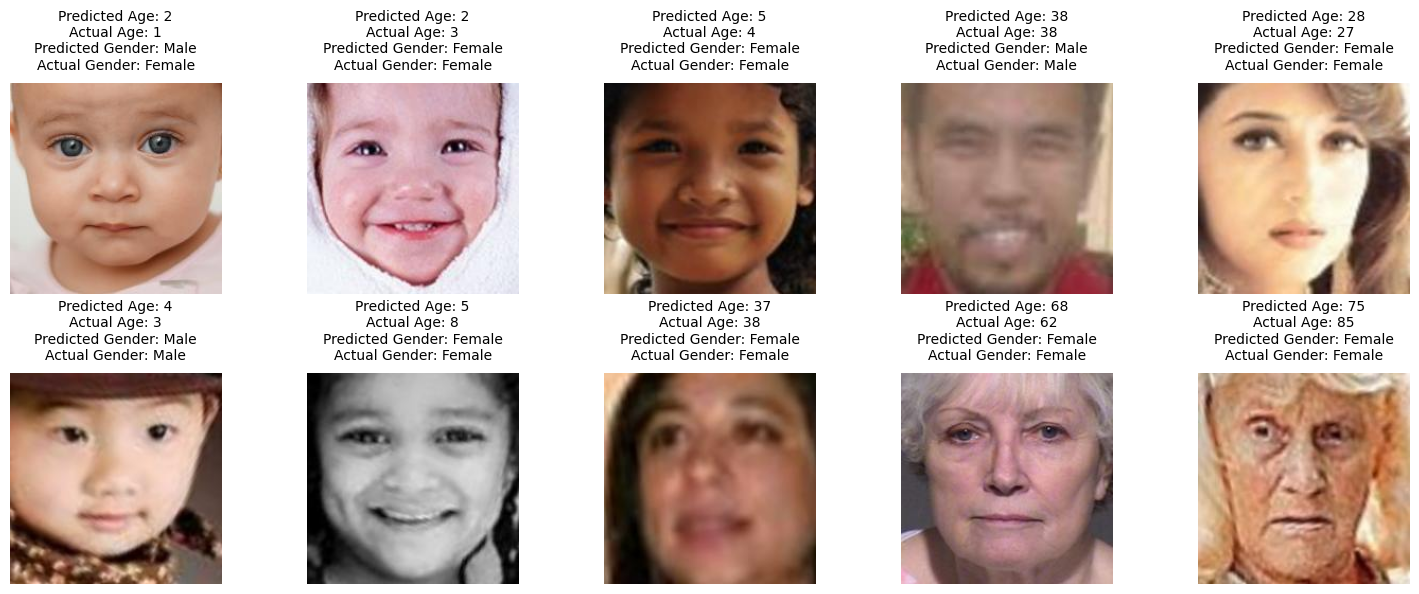

In [ ]:
# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed

for i in range(10):
    img_to_test = image_paths_test[i]  # Use the current index 'i' to select a different image
    features = get_image_features(img_to_test)
    pred = model_all.predict(features)

    gender_pred = map_gender_label(round(pred[0][0][0]))
    age_pred = round(pred[1][0][0])

    # Load the image
    img = np.array(load_img(img_to_test))

    # Display the image in the corresponding subplot
    ax = axes[i // 5, i % 5]  # Calculate the position in the grid
    ax.imshow(img)

    # Include actual labels in the title
    ax.set_title(f'Predicted Age: {age_pred}\n'
                 f'Actual Age: {age_labels_test[i]}\n'
                 f'Predicted Gender: {gender_pred}\n'
                 f'Actual Gender: {map_gender_label(gender_labels_test[i])}',
                 fontsize=10, pad=10)

    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
# Lists to store predictions
predicted_genders = []
predicted_ages = []

# Iterate over some test images
for img_to_test in image_paths_test[:3000]:
    features = get_image_features(img_to_test)  # Preprocess the image
    pred = model_all.predict(features, verbose=0)

    # Get predictions
    predicted_genders.append(round(pred[0][0][0]))  # Gender prediction
    predicted_ages.append(round(pred[1][0][0]))      # Age prediction

# Convert lists to numpy arrays for accuracy calculation
predicted_genders = np.array(predicted_genders)
predicted_ages = np.array(predicted_ages)

# Calculate accuracy for gender
gender_accuracy = accuracy_score(gender_labels_test[:3000], predicted_genders)
print(f'Test Gender Accuracy: {gender_accuracy * 100:.2f}%')

# Optionally, if you want to calculate a metric for age predictions:
# For age, you may want to use a different metric (e.g., Mean Absolute Error)
age_mae = mean_squared_error(age_labels_test[:3000], predicted_ages) # MAE for age predictions
age_rmae = np.sqrt(age_mae)
print(f'Mean Absolute Error for Age: {age_mae:.2f}')
print(f'Root Mean Absolute Error for Age: {age_rmae:.2f}')

Test Gender Accuracy: 84.03%
Mean Absolute Error for Age: 49.93
Root Mean Absolute Error for Age: 7.07


In [ ]:
report = classification_report(gender_labels_test[:3000], predicted_genders)
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1349
           1       0.84      0.88      0.86      1651

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



Confusion Matrix
[[1063  286]
 [ 193 1458]]


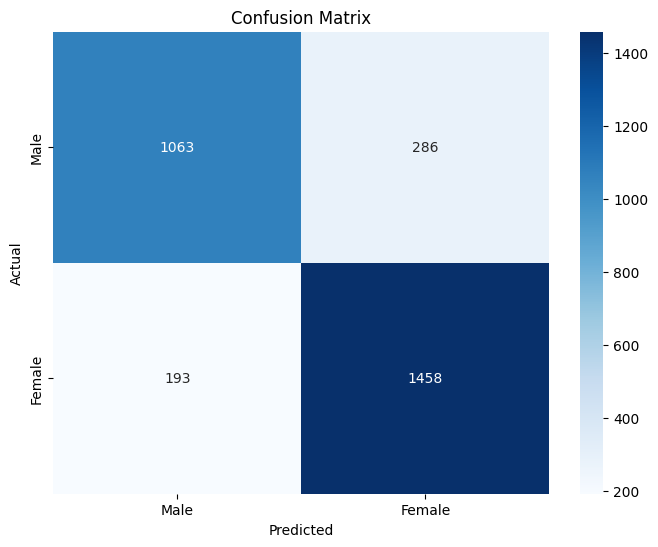

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(gender_labels_test[:3000], predicted_genders)
print("Confusion Matrix")
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

741/741 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


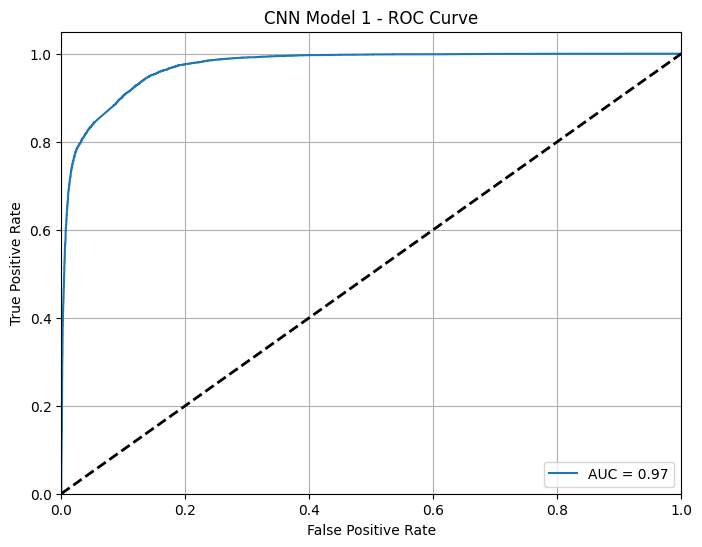

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# 1. CNN Model 1
y_pred_cnn1 = model_all.predict(X)  # Predict on the entire dataset
y_pred_cnn1_probs = y_pred_cnn1[0]  # Gender probabilities from the first output
roc_auc_cnn1 = roc_auc_score(y_gender, y_pred_cnn1_probs)  # Calculate AUC-ROC
fpr_cnn1, tpr_cnn1, _ = roc_curve(y_gender, y_pred_cnn1_probs)  # Compute ROC curve

# Plot for CNN Model 1
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn1, tpr_cnn1, label=f'AUC = {roc_auc_cnn1:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model 1 - ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## **CNN Model (After Tuning Phase)**

In [ ]:
input_shape = (128,128,1)
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(conv_1)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
conv_4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv_3)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_4)


flatten = Flatten()(max_2)

# fully connected layers
dense_1 = Dense(128, activation='relu')(flatten)
dense_2 = Dense(128, activation='relu')(flatten)

dropout_1 = Dropout(0.5)(dense_1)
dropout_2 = Dropout(0.5)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out', kernel_regularizer=l2(0.001))(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out', kernel_regularizer=l2(0.001))(dropout_2)

model_all2 = Model(inputs=[inputs], outputs=[output_1, output_2])

model_all2.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    optimizer='adam',
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

In [ ]:
model_all2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 126,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 124, 124,  │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 62, 62,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 60, 60,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 58, 58,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 29, 29,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 53824)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  6,889,600 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  6,889,600 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,844,450 (52.81 MB)

 Trainable params: 13,844,450 (52.81 MB)

 Non-trainable params: 0 (0.00 B)

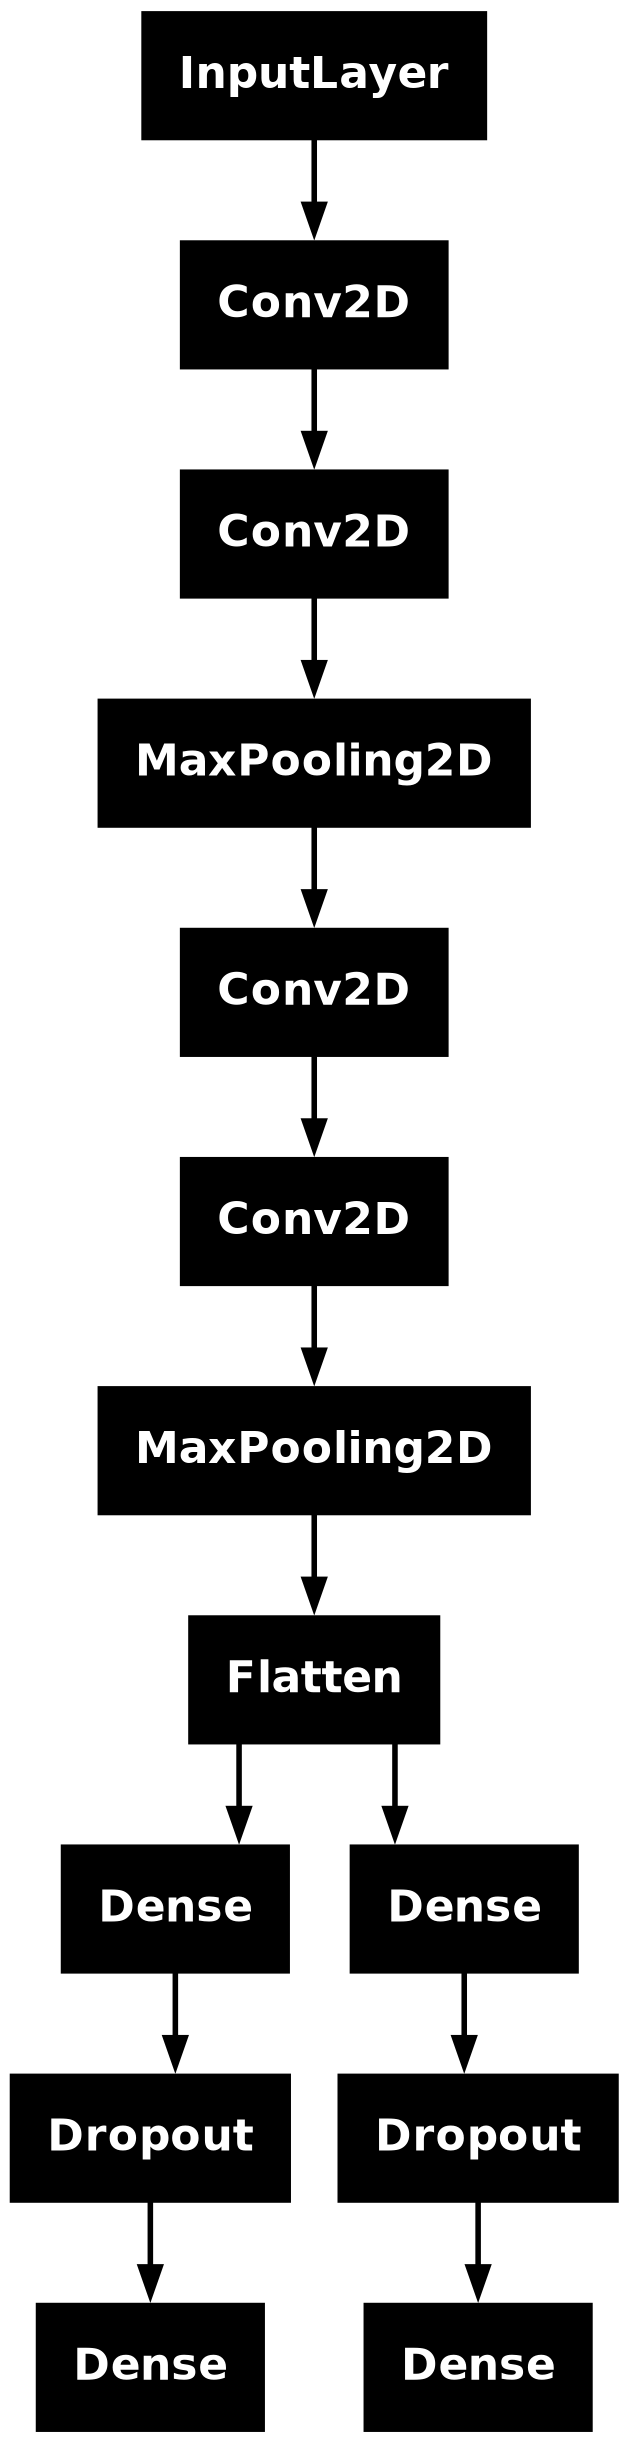

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_all2)

In [ ]:
history2 = model_all2.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=25, validation_split=0.2)

Epoch 1/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - age_out_mae: 16.3537 - gender_out_accuracy: 0.5581 - loss: 17.0851 - val_age_out_mae: 10.1138 - val_gender_out_accuracy: 0.8121 - val_loss: 10.5379
Epoch 2/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - age_out_mae: 10.4412 - gender_out_accuracy: 0.7808 - loss: 10.9018 - val_age_out_mae: 8.1761 - val_gender_out_accuracy: 0.8420 - val_loss: 8.5277
Epoch 3/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - age_out_mae: 9.3670 - gender_out_accuracy: 0.8043 - loss: 9.7790 - val_age_out_mae: 7.6623 - val_gender_out_accuracy: 0.8461 - val_loss: 7.9848
Epoch 4/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - age_out_mae: 8.4521 - gender_out_accuracy: 0.8156 - loss: 8.8139 - val_age_out_mae: 8.2740 - val_gender_out_accuracy: 0.8606 - val_loss: 8.5712
Epoch 5/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - age_out_mae: 8.1154 - gender_out_accuracy: 0.8305 - loss: 8.4490 - val_age_out_mae: 7.6984 - val_gender_out_accuracy: 0.8676 - val_loss: 7

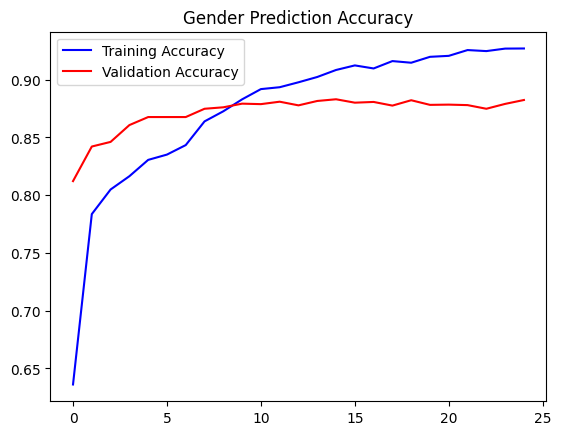

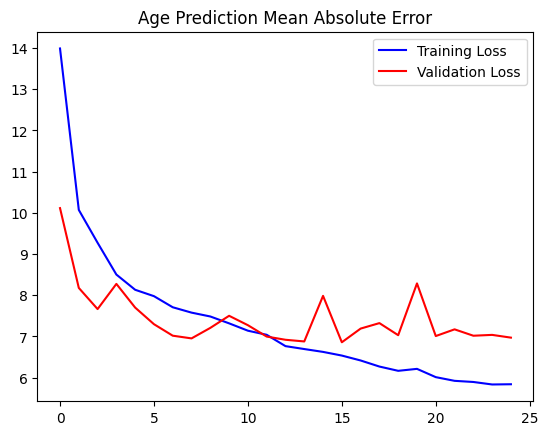

In [ ]:
# plot results for gender
acc = history2.history['gender_out_accuracy']
val_acc = history2.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Prediction Accuracy')
plt.legend()
plt.figure()

# plot results for age
loss = history2.history['age_out_mae']
val_loss = history2.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Age Prediction Mean Absolute Error')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


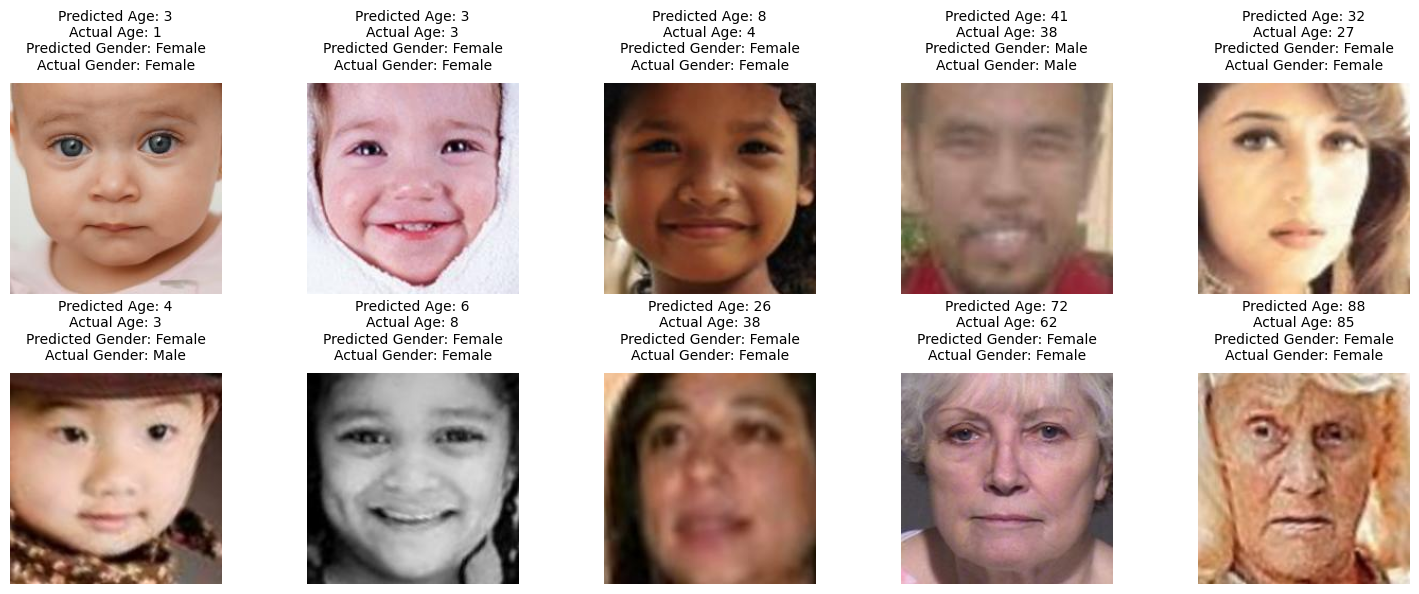

In [ ]:
# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed

for i in range(10):
    img_to_test = image_paths_test[i]  # Use the current index 'i' to select a different image
    features = get_image_features(img_to_test)
    pred = model_all2.predict(features)

    gender_pred = map_gender_label(round(pred[0][0][0]))
    age_pred = round(pred[1][0][0])

    # Load the image
    img = np.array(load_img(img_to_test))

    # Display the image in the corresponding subplot
    ax = axes[i // 5, i % 5]  # Calculate the position in the grid
    ax.imshow(img)

    # Include actual labels in the title
    ax.set_title(f'Predicted Age: {age_pred}\n'
                 f'Actual Age: {age_labels_test[i]}\n'
                 f'Predicted Gender: {gender_pred}\n'
                 f'Actual Gender: {map_gender_label(gender_labels_test[i])}',
                 fontsize=10, pad=10)

    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
# Lists to store predictions
predicted_genders = []
predicted_ages = []

# Iterate over some test images
for img_to_test in image_paths_test[3000:6000]:
    features = get_image_features(img_to_test)  # Preprocess the image
    pred = model_all2.predict(features, verbose=0)

    # Get predictions
    predicted_genders.append(round(pred[0][0][0]))  # Gender prediction
    predicted_ages.append(round(pred[1][0][0]))      # Age prediction

# Convert lists to numpy arrays for accuracy calculation
predicted_genders = np.array(predicted_genders)
predicted_ages = np.array(predicted_ages)

# Calculate accuracy for gender
gender_accuracy = accuracy_score(gender_labels_test[3000:6000], predicted_genders)
print(f'Test Gender Accuracy: {gender_accuracy * 100:.2f}%')

# Optionally, if you want to calculate a metric for age predictions:
# For age, you may want to use a different metric (e.g., Mean Absolute Error)
age_mae = mean_squared_error(age_labels_test[3000:6000], predicted_ages) # MAE for age predictions
age_rmae = np.sqrt(age_mae)
print(f'Mean Absolute Error for Age: {age_mae:.2f}')
print(f'Root Mean Absolute Error for Age: {age_rmae:.2f}')

Test Gender Accuracy: 94.23%
Mean Absolute Error for Age: 39.56
Root Mean Absolute Error for Age: 6.29


In [ ]:
report = classification_report(gender_labels_test[3000:6000], predicted_genders)
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1324
           1       0.92      0.98      0.95      1675
           3       0.00      0.00      0.00         1

    accuracy                           0.94      3000
   macro avg       0.63      0.63      0.63      3000
weighted avg       0.94      0.94      0.94      3000



Confusion Matrix
[[1191  133    0]
 [  39 1636    0]
 [   0    1    0]]


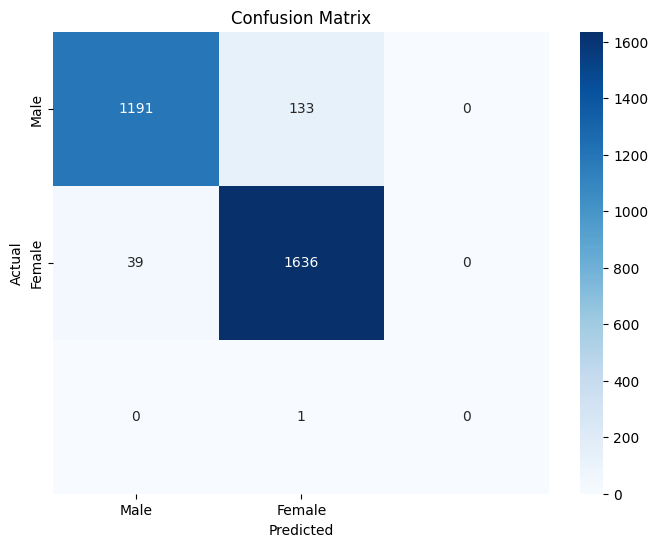

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(gender_labels_test[3000:6000], predicted_genders)
print("Confusion Matrix")
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_all2.save("model_all2.h5")

741/741 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


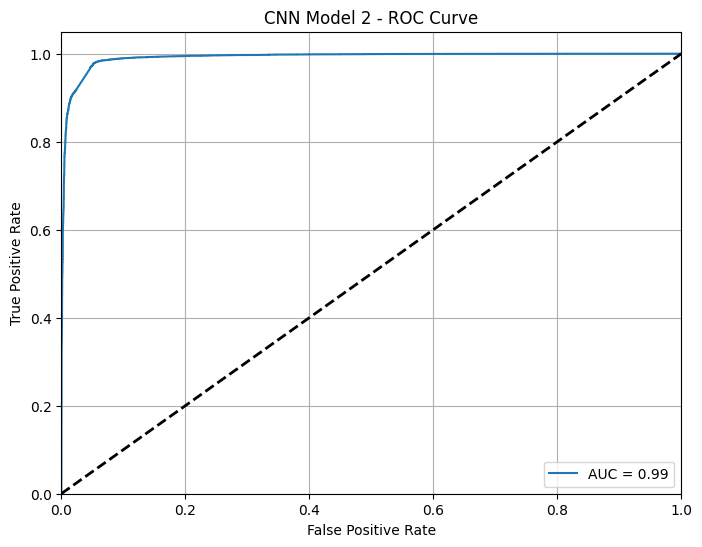

In [ ]:
# 2. CNN Model 2
y_pred_cnn2 = model_all2.predict(X)  # Predict on the entire dataset
y_pred_cnn2_probs = y_pred_cnn2[0]  # Gender probabilities from the second output
roc_auc_cnn2 = roc_auc_score(y_gender, y_pred_cnn2_probs)  # Calculate AUC-ROC
fpr_cnn2, tpr_cnn2, _ = roc_curve(y_gender, y_pred_cnn2_probs)  # Compute ROC curve

# Plot for CNN Model 2
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn2, tpr_cnn2, label=f'AUC = {roc_auc_cnn2:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model 2 - ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **KNN Model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Flatten the image data for k-NN
X_flattened = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_gender_train, y_gender_test = train_test_split(X_flattened, y_gender, test_size=0.2, random_state=42)
X_train_age, X_test_age, y_age_train, y_age_test = train_test_split(X_flattened, y_age, test_size=0.2, random_state=42)

# Initialize optimized k-NN models
knn_gender = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')  # Gender classification
knn_age = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')      # Age regression

# Train k-NN models
knn_gender.fit(X_train, y_gender_train)
knn_age.fit(X_train_age, y_age_train)

# Predict gender and age
y_gender_pred = knn_gender.predict(X_test)
y_age_pred = knn_age.predict(X_test_age)

Improved k-NN Gender Classification Accuracy: 73.75%
Classification Report for Gender:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      2476
           1       0.75      0.67      0.71      2266

    accuracy                           0.74      4742
   macro avg       0.74      0.73      0.74      4742
weighted avg       0.74      0.74      0.74      4742

Confusion Matrix for Gender:
[[1971  505]
 [ 740 1526]]


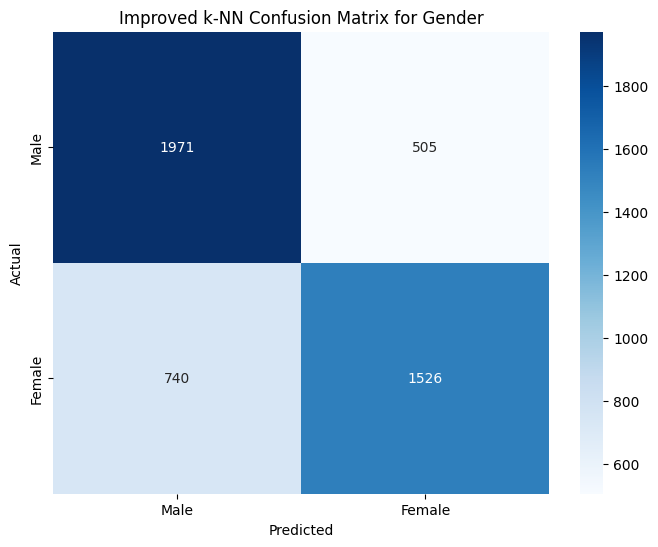

In [ ]:
# Evaluate k-NN for gender classification
gender_accuracy = accuracy_score(y_gender_test, y_gender_pred)
print(f"Improved k-NN Gender Classification Accuracy: {gender_accuracy * 100:.2f}%")
print("Classification Report for Gender:")
print(classification_report(y_gender_test, y_gender_pred))

# Confusion matrix for gender classification
conf_matrix_gender = confusion_matrix(y_gender_test, y_gender_pred)
print("Confusion Matrix for Gender:")
print(conf_matrix_gender)

# Plot confusion matrix for gender
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Improved k-NN Confusion Matrix for Gender')
plt.show()

I k-NN Mean Absolute Error for Age: 11.94
 k-NN Root Mean Absolute Error for Age: 16.38


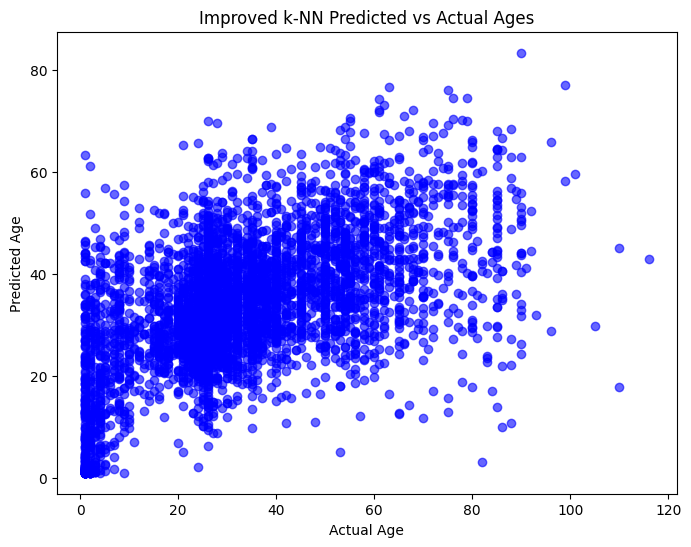

In [ ]:
# Evaluate k-NN for age regression
age_mae = mean_absolute_error(y_age_test, y_age_pred)
age_rmae = np.sqrt(mean_squared_error(y_age_test, y_age_pred))
print(f"I k-NN Mean Absolute Error for Age: {age_mae:.2f}")
print(f" k-NN Root Mean Absolute Error for Age: {age_rmae:.2f}")

# Plot predicted vs actual ages
plt.figure(figsize=(8, 6))
plt.scatter(y_age_test, y_age_pred, alpha=0.6, color='blue')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Improved k-NN Predicted vs Actual Ages')
plt.show()

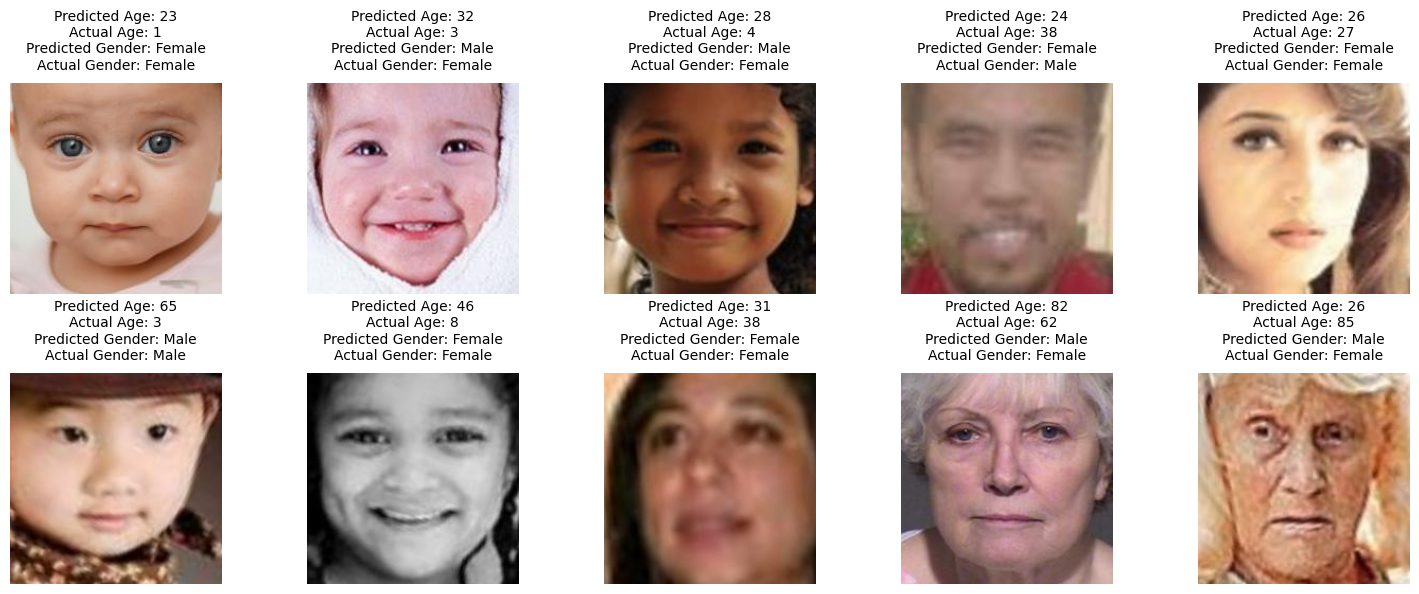

In [ ]:
# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed

for i in range(10):
    img_to_test = image_paths_test[i]  # Use the current index 'i' to select a different image
    img_flattened = X_flattened[i].reshape(1, -1)  # Flatten the image for k-NN
    gender_pred = knn_gender.predict(img_flattened)[0]  # Predict gender using k-NN
    age_pred = round(knn_age.predict(img_flattened)[0])  # Predict age using k-NN

    # Load the original image
    img = np.array(load_img(img_to_test))

    # Display the image in the corresponding subplot
    ax = axes[i // 5, i % 5]  # Calculate the position in the grid
    ax.imshow(img)

    # Include actual labels and k-NN predictions in the title
    ax.set_title(f'Predicted Age: {age_pred}\n'
                 f'Actual Age: {age_labels_test[i]}\n'
                 f'Predicted Gender: {map_gender_label(gender_pred)}\n'
                 f'Actual Gender: {map_gender_label(gender_labels_test[i])}',
                 fontsize=10, pad=10)

    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

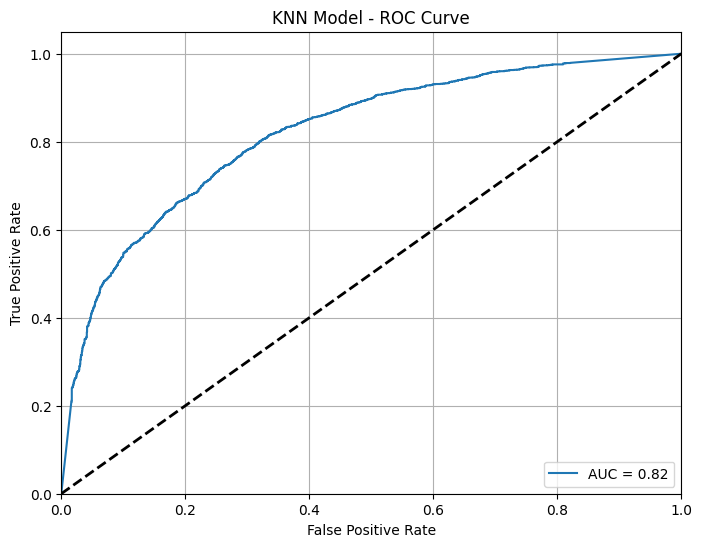

In [ ]:
# KNN Model
y_pred_knn_probs = knn_gender.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc_knn = roc_auc_score(y_gender_test, y_pred_knn_probs)  # Calculate AUC-ROC
fpr_knn, tpr_knn, _ = roc_curve(y_gender_test, y_pred_knn_probs)  # Compute ROC curve

# Plot for KNN Model
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {roc_auc_knn:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Model - ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **Logistic and Linear Regression Model**

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression

# Flatten the image data
X_flattened = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_gender_train, y_gender_test = train_test_split(X_flattened, y_gender, test_size=0.2, random_state=42)
X_train_age, X_test_age, y_age_train, y_age_test = train_test_split(X_flattened, y_age, test_size=0.2, random_state=42)

# --- Linear Regression for Age Prediction ---
linear_age = LinearRegression()
linear_age.fit(X_train_age, y_age_train)

# Predict age
y_age_pred = linear_age.predict(X_test_age)

Linear Regression Mean Absolute Error for Age: 34.44
Linear Regression Root Mean Absolute Error for Age: 50.64


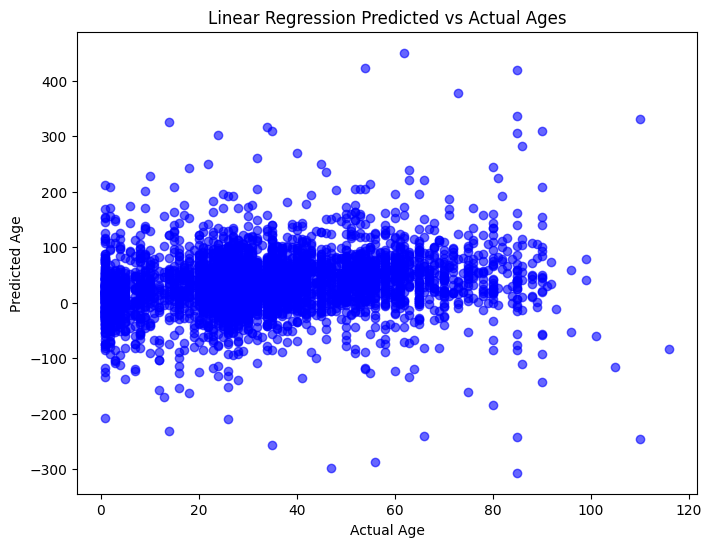

In [ ]:
# Evaluate Linear Regression for age prediction
age_mae = mean_absolute_error(y_age_test, y_age_pred)
age_rmae = np.sqrt(mean_squared_error(y_age_test, y_age_pred))
print(f"Linear Regression Mean Absolute Error for Age: {age_mae:.2f}")
print(f"Linear Regression Root Mean Absolute Error for Age: {age_rmae:.2f}")

# Plot predicted vs actual ages
plt.figure(figsize=(8, 6))
plt.scatter(y_age_test, y_age_pred, alpha=0.6, color='blue')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Linear Regression Predicted vs Actual Ages')
plt.show()

Logistic Regression Gender Classification Accuracy: 85.34%
Classification Report for Gender:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2476
           1       0.85      0.85      0.85      2266

    accuracy                           0.85      4742
   macro avg       0.85      0.85      0.85      4742
weighted avg       0.85      0.85      0.85      4742

Confusion Matrix for Gender:
[[2126  350]
 [ 345 1921]]


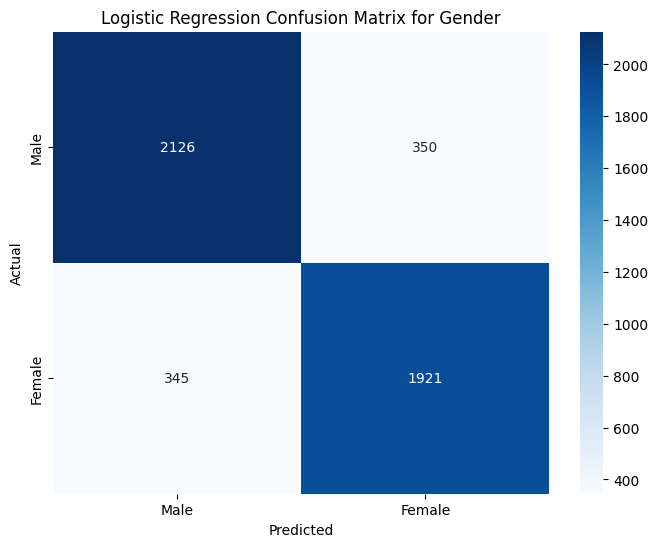

In [ ]:
# --- Logistic Regression for Gender Classification ---
logistic_gender = LogisticRegression()
logistic_gender.fit(X_train, y_gender_train)

# Predict gender
y_gender_pred = logistic_gender.predict(X_test)

# Evaluate Logistic Regression for gender classification
gender_accuracy = accuracy_score(y_gender_test, y_gender_pred)
print(f"Logistic Regression Gender Classification Accuracy: {gender_accuracy * 100:.2f}%")
print("Classification Report for Gender:")
print(classification_report(y_gender_test, y_gender_pred))

# Confusion matrix for gender classification
conf_matrix_gender = confusion_matrix(y_gender_test, y_gender_pred)
print("Confusion Matrix for Gender:")
print(conf_matrix_gender)

# Plot confusion matrix for gender
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix for Gender')
plt.show()

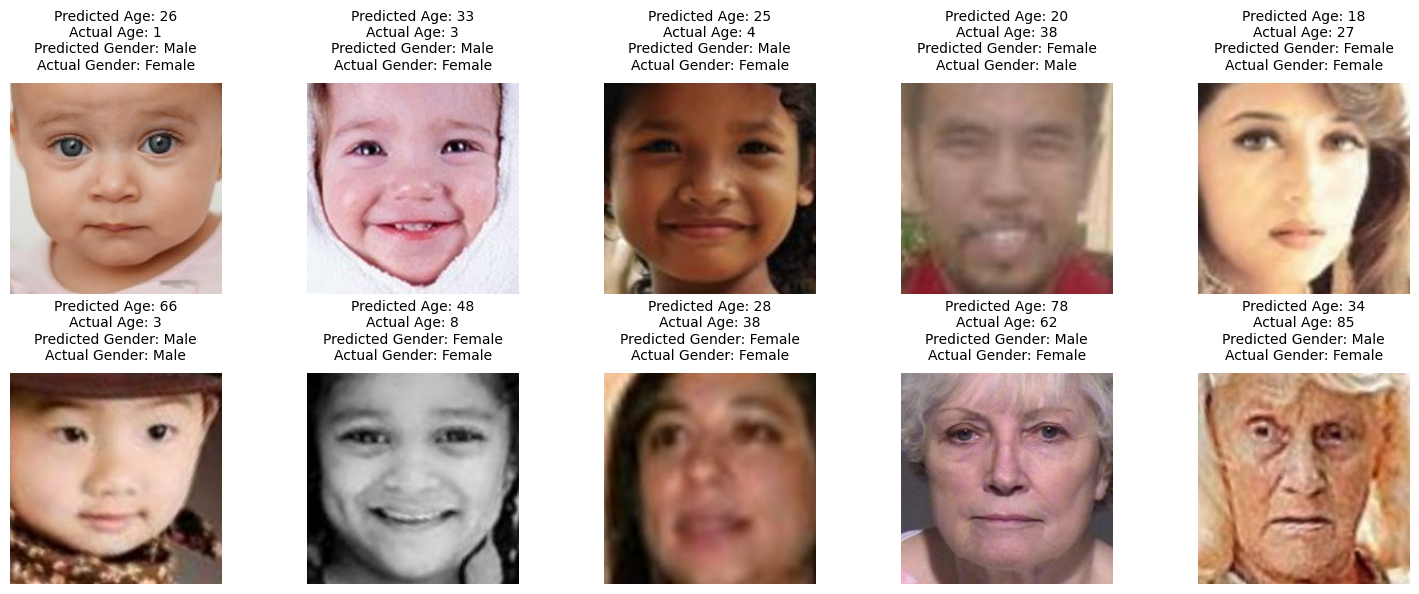

In [ ]:
# --- Visualize Predictions for Age and Gender ---
# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed

for i in range(10):
    img_to_test = image_paths_test[i]  # Use the current index 'i' to select a different image
    img_flattened = X_flattened[i].reshape(1, -1)  # Flatten the image for the models

    # Predict gender and age
    gender_pred = logistic_gender.predict(img_flattened)[0]
    age_pred = round(linear_age.predict(img_flattened)[0])  # Round the age prediction

    # Load the original image
    img = np.array(load_img(img_to_test))

    # Display the image in the corresponding subplot
    ax = axes[i // 5, i % 5]  # Calculate the position in the grid
    ax.imshow(img)

    # Include actual labels and predictions in the title
    ax.set_title(f'Predicted Age: {age_pred}\n'
                 f'Actual Age: {age_labels_test[i]}\n'
                 f'Predicted Gender: {map_gender_label(gender_pred)}\n'
                 f'Actual Gender: {map_gender_label(gender_labels_test[i])}',
                 fontsize=10, pad=10)

    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

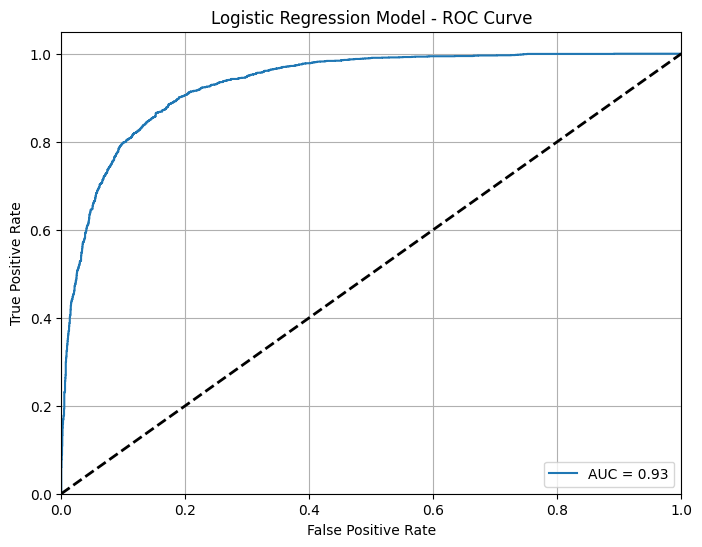

In [ ]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
y_pred_logistic_probs = logistic_gender.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc_logistic = roc_auc_score(y_gender_test, y_pred_logistic_probs)  # Calculate AUC-ROC
fpr_logistic, tpr_logistic, _ = roc_curve(y_gender_test, y_pred_logistic_probs)  # Compute ROC curve

# Plot for Logistic Regression Model
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'AUC = {roc_auc_logistic:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Model - ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()